In [5]:
# CONEXIÓN
# Importamos librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import boto3

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cargar variables del entorno (.env)
load_dotenv(".env")

aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_region = os.getenv("AWS_DEFAULT_REGION")

print(" Variables AWS cargadas correctamente:", aws_access_key_id[:8], "*****")

# Conectarse a S3 (verificar permisos)
s3 = boto3.client(
    "s3",
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=aws_region
)

bucket = "zrive-ds-data"
prefix = "groceries/sampled-datasets/"

try:
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    print("Archivos disponibles en S3:")
    for obj in response.get("Contents", []):
        print("-", obj["Key"])
except Exception as e:
    print("No se pudieron listar los objetos (puede que no tengas permisos).")
    print(e)


 Variables AWS cargadas correctamente: AKIAXN64 *****
Archivos disponibles en S3:
- groceries/sampled-datasets/abandoned_carts.parquet
- groceries/sampled-datasets/inventory.parquet
- groceries/sampled-datasets/orders.parquet
- groceries/sampled-datasets/regulars.parquet
- groceries/sampled-datasets/users.parquet


In [6]:
# DESCARGA DE DATOS
import os
from botocore.exceptions import ClientError

files_to_download = [
    "groceries/sampled-datasets/orders.parquet",
    "groceries/sampled-datasets/regulars.parquet",
    "groceries/sampled-datasets/abandoned_carts.parquet",
    "groceries/sampled-datasets/inventory.parquet",
    "groceries/sampled-datasets/users.parquet",
]

os.makedirs("data/groceries", exist_ok=True)

for file_key in files_to_download:
    local_path = os.path.join("data/groceries", os.path.basename(file_key))
    try:
        print(f"Descargando {file_key} → {local_path}")
        s3.download_file(bucket, file_key, local_path)
    except ClientError as e:
        print(f"⚠️ Error al descargar {file_key}: {e}")


Descargando groceries/sampled-datasets/orders.parquet → data/groceries\orders.parquet
Descargando groceries/sampled-datasets/regulars.parquet → data/groceries\regulars.parquet
Descargando groceries/sampled-datasets/abandoned_carts.parquet → data/groceries\abandoned_carts.parquet
Descargando groceries/sampled-datasets/inventory.parquet → data/groceries\inventory.parquet
Descargando groceries/sampled-datasets/users.parquet → data/groceries\users.parquet


In [8]:
# Hasta aquí he comprobado que todo funciona correctamente y he descargado los datos.

In [9]:
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)

In [10]:
import pandas as pd
import os

# Definimos la ruta base
data_path = "data/groceries"

# Cargamos datasets
orders = pd.read_parquet(os.path.join(data_path, "orders.parquet"))
regulars = pd.read_parquet(os.path.join(data_path, "regulars.parquet"))
abandoned = pd.read_parquet(os.path.join(data_path, "abandoned_carts.parquet"))
inventory = pd.read_parquet(os.path.join(data_path, "inventory.parquet"))
users = pd.read_parquet(os.path.join(data_path, "users.parquet"))

# Mostramos tamaños
for name, df in {
    "Orders": orders,
    "Regulars": regulars,
    "Abandoned carts": abandoned,
    "Inventory": inventory,
    "Users": users
}.items():
    print(f"{name:18} → {df.shape[0]} filas, {df.shape[1]} columnas")

# Primeras filas de cada usuario
orders.head()

Orders             → 8773 filas, 6 columnas
Regulars           → 18105 filas, 3 columnas
Abandoned carts    → 5457 filas, 4 columnas
Inventory          → 1733 filas, 6 columnas
Users              → 4983 filas, 10 columnas


,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


In [11]:
# ESTUDIO DE ORDERS (PEDIDOS REALIZADOS)
# Observamos las columnas de orders.
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


In [12]:
# En este caso, todas las columnas contienen todos sus valores válidos (no nulos), ya que hay 8773 filas y en cada columna hay 8773 valores no nulos.

In [13]:
# Realizo algunas estadísticas descriptivas

In [14]:
orders.describe() #media, sd, min, max, percentiles (para las numéricas, aunque en este caso no tiene mucho sentido hacerlo)

,id,created_at,order_date,user_order_seq
count,8.773000e+03,8773,8773,8773.000000
mean,3.684684e+12,2021-08-22 03:54:18.750028,2021-08-21 12:47:21.262966,2.445116
min,2.204073e+12,2020-04-30 14:32:19,2020-04-30 00:00:00,1.000000
25%,3.690255e+12,2021-04-25 11:50:37,2021-04-25 00:00:00,1.000000
50%,3.846692e+12,2021-10-11 11:29:44,2021-10-11 00:00:00,1.000000
75%,3.945086e+12,2022-01-03 18:14:23,2022-01-03 00:00:00,3.000000
max,4.026732e+12,2022-03-14 00:24:59,2022-03-14 00:00:00,25.000000
std,4.145437e+11,NaN,NaN,2.707693


In [15]:
# Quiero ver cuantos pedidos ha realizado cada usuario
orders['user_id'].value_counts()

user_id
ba7176c5f870cd86e51ecc4375e0becc8cc305845e70b9384ba0d4d156c6099ec96602b15420cb1ff69b6b9adcf9249d09489d511565531c4e928a92157b16d6    25
114e78a8909ad3f9d481e66563998301eff9e7cd1b2d002b77ffc26619f0ef7a6e877d5b3460e0e0bde2d7c67787c66d7384ccf34b4aa4fa1409e978cf47e670    22
04e9d7967f4dfd7d40175f130f1c80f62204ff697df92dfd83407ace7997b6744b6a7cab0382e60f7264b13ba3f03c64f016ae9dca664885ace6020aba3b5131    22
1296e1e72f7f43ff28d7d285f880ad4d213fa8139233c78ad2673af4cc0c1c297180254da494cc3b934858347822be437eeb072acb1403e9476dc0b2f6a83cbe    21
a655b992a3ee5f6aa9f5ab5662c4befac1fdc45c99885b173618b661ca7381c383b1364e977c9f51366cdc62e4d92ff383e8e5aac7ea9a552059be2671de24e2    21
                                                                                                                                    ..
720193c88605b61f880b340ca9a02c673241a37ff74f7d20639fc933ed5438a3b96076b85f168231d34779994c26810adbb24e0d842639837780649a4baf16a8     1
76f2a192182b2d88816355ac40307d4323c6d62da2a27d9

In [16]:
# El usuario que más pedido ha realizado ha hecho 25 pediddos.
# Mostrar las 5 primeras filas de la columna de Ordered_items, y muestra los productos comprados en esos 5 pedidos
orders['ordered_items'].head()

10    [33618849693828, 33618860179588, 3361887404045...
20    [33618835243140, 33618835964036, 3361886244058...
21    [33618891145348, 33618893570180, 3361889766618...
34    [33618830196868, 33618846580868, 3361891234624...
49    [33667166699652, 33667166699652, 3366717122163...
Name: ordered_items, dtype: object

In [17]:
# En conclusión, de orders saco que se hicieron 8773 pedidos y el cliente que más pedido realizó hizó 25 pedidos.

In [18]:
# ESTUDIO DE REGULARS (CLIENTES REGULARES)
regulars.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


In [19]:
# Me devuelve, el usuario, productos variantes (pueden ser comprados, añadidos a la cesta o vistos) y la fecha en qué se realizó

In [20]:
regulars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


In [21]:
# De nuevo, todas las columnas tiene valores válidos.
variant_counts = regulars['variant_id'].value_counts() # productos más populares
variant_counts

variant_id
34081589887108    253
34370361229444    127
33973249081476    114
34370915041412    112
34284951863428    105
                 ... 
39544243552388      1
39478260826244      1
39711187894404      1
39272601452676      1
39459281010820      1
Name: count, Length: 1843, dtype: int64

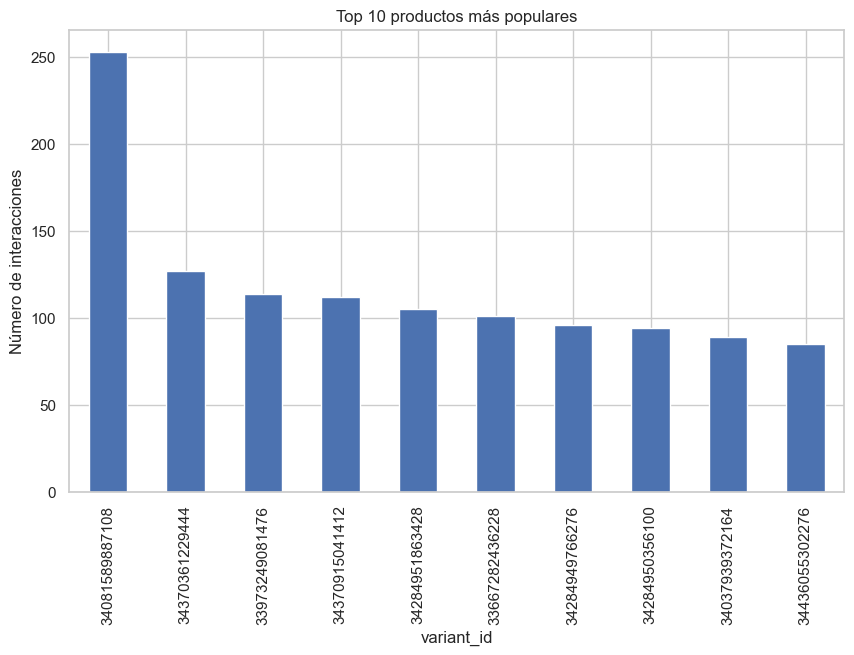

In [22]:
# Gráfico de los 10 productos más regulares
variant_counts.head(10).plot(kind='bar', title='Top 10 productos más populares')
plt.ylabel('Número de interacciones')
plt.show()

In [23]:
# En resumen, de regulars saco que el producto más popular que se repite 253 veces es 34081589887108.

In [24]:
# REVISAR!!!!!!!! NO CARGA

In [25]:
# Estudio sobre inventory: información sobre cada producto

In [26]:
inventory.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [27]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


In [28]:
# Productos con mayor descuento
inventory['discount'] = inventory['compare_at_price'] - inventory['price']
inventory['discount_pct'] = (inventory['discount'] / inventory['compare_at_price']) * 100


In [29]:
top_discount = inventory.sort_values(by='discount_pct', ascending=False).head(10)
print("Top 10 productos con mayor descuento:")
print(top_discount[['variant_id', 'tags', 'price', 'compare_at_price', 'discount', 'discount_pct']])

Top 10 productos con mayor descuento:
          variant_id                                               tags  \
104   34368927170692  [pasta-pizza-sauce, tinned-tomatoes-puree-pass...   
917   39459277340804                                        [hand-soap]   
731   33667196092548  [hand-soap, household & cleaning, toiletries &...   
149   34369153564804  [pasta-pizza-sauce, tinned-tomatoes-puree-pass...   
1610  33826415706244                         [discontinue, eco, size-3]   
830   39349425340548                    [suncream, toiletries & health]   
220   34173021192324                                           [squash]   
1186  39459283665028                                  [facial-skincare]   
182   39459279798404                                  [facial-skincare]   
406   39600950378628                                  [crackers, vegan]   

      price  compare_at_price  discount  discount_pct  
104    0.83             11.99     11.16     93.077565  
917    2.19             

In [30]:
from collections import Counter

In [31]:
# Qué productos son los que tienen mayor descuento

# Convertir todo a string y eliminar NaN
tags_as_str = top_discount['tags'].dropna().astype(str)

# Separar etiquetas y contar
all_tags = tags_as_str.str.split(',').sum()
tag_counts = Counter([tag.strip() for tag in all_tags])

print("Etiquetas más frecuentes en los productos con mayor descuento:")
print(tag_counts.most_common())


Etiquetas más frecuentes en los productos con mayor descuento:
[("['pasta-pizza-sauce' 'tinned-tomatoes-puree-passata']", 2), ("['facial-skincare']", 2), ("['hand-soap']", 1), ("['hand-soap' 'household & cleaning' 'toiletries & health']", 1), ("['discontinue' 'eco' 'size-3']", 1), ("['suncream' 'toiletries & health']", 1), ("['squash']", 1), ("['crackers' 'vegan']", 1)]


In [32]:
# Veamos si los productos con mayor descuento son los más regulares
# Top 20 productos con mayor descuento
top_discount = inventory.sort_values(by='discount_pct', ascending=False).head(20)

In [33]:
# Contamos las veces que aparecen estos productos entre los clientes + regulares
regular_top = regulars[regulars['variant_id'].isin(top_discount['variant_id'])]
variant_counts = regular_top['variant_id'].value_counts()

In [34]:
variant_counts # el producto del top descuento que más se repite entre usuarios, se repite 5 veces

variant_id
33667185279108    50
34173021192324    35
33667185311876    23
39459277340804    20
33719433986180    11
39349425340548     5
33667228663940     5
34246816923780     4
34246816989316     4
33667196092548     3
33667228532868     2
39600950411396     2
39459279798404     2
39542988898436     2
34415988179076     2
Name: count, dtype: int64

In [36]:
# Relación entre los productos con mayor descuento y los clientes más regulares
analysis = inventory.set_index('variant_id').join(variant_counts.rename('num_interactions'))
analysis = analysis.fillna(0)  # rellenar variantes sin interacciones
analysis_filtered = analysis[analysis['num_interactions'] > 0]
analysis

,price,compare_at_price,vendor,product_type,tags,discount,discount_pct,num_interactions
variant_id,,,,,,,,
39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",0.06,1.904762,0.0
34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]",0.51,9.272727,0.0
34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll],0.30,7.518797,0.0
33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]",0.20,10.050251,0.0
33803537973380,1.99,2.09,colgate,dental,[dental-accessories],0.10,4.784689,0.0
...,...,...,...,...,...,...,...,...
39539419218052,4.99,5.99,bother,,[household-sundries],1.00,16.694491,0.0
34534187368580,4.69,5.49,tommeetippee,baby-accessories,[feeding-weaning],0.80,14.571949,0.0
33826439594116,15.39,17.15,colief,baby-accessories,[feeding-weaning],1.76,10.262391,0.0


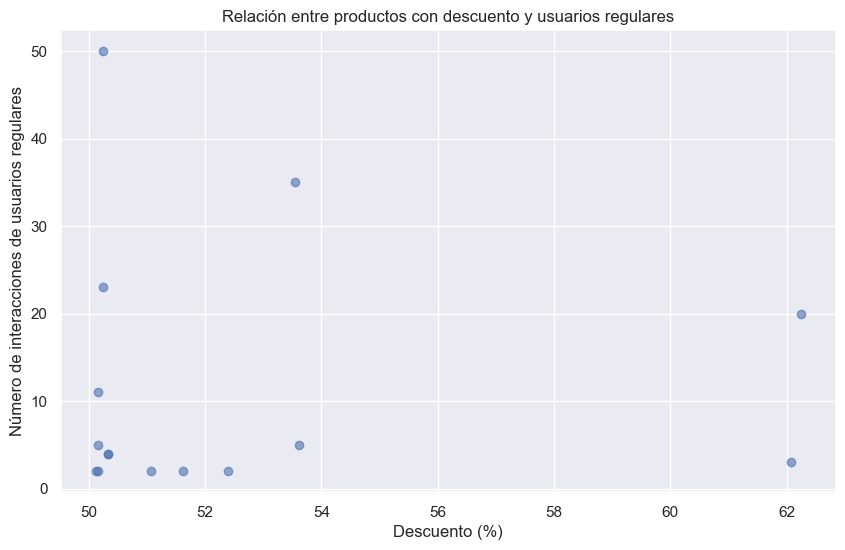

In [37]:
# Gráfico: relación entre descuento y número de interacciones
plt.figure(figsize=(10,6))
plt.scatter(analysis_filtered['discount_pct'], analysis_filtered['num_interactions'], alpha=0.6)
plt.xlabel('Descuento (%)')
plt.ylabel('Número de interacciones de usuarios regulares')
plt.title('Relación entre productos con descuento y usuarios regulares')
plt.show()

In [39]:
# Correlación
correlation = analysis_filtered['discount_pct'].corr(analysis_filtered['num_interactions'])
print("Correlación entre descuento y número de interacciones:", correlation)

Correlación entre descuento y número de interacciones: 0.02774243315492273


In [46]:
# Por tanto, no significa que un mayor descuento implique un mayor número de ventas entre los usuarios regulares

In [47]:
# ESTUDIO SOBRE LOS VENDEDORES
inventory['vendor'].nunique() # cuántos vendedores hay
inventory['vendor'].value_counts().head(10) # los 10 vendedores con + productos

vendor
biona            69
ecover           34
napolina         28
faithinnature    27
method           26
hiderfoods       24
greencuisine     24
various          23
ellaskitchen     18
febreze          17
Name: count, dtype: int64

In [48]:
# Veamos qué vendedores venden más caro o aplican más descuentos
inventory.groupby('vendor')[['price', 'compare_at_price']].mean().head()

,price,compare_at_price
vendor,,
7up,3.190000,4.000000
absolut,19.990000,20.690000
alpro,13.715000,14.500000
always,1.656667,1.993333
ambrosia,1.995000,2.085000


In [50]:
# ESTUDIO SOBRE LOS USUARIOS
users.head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [51]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


In [57]:
# Observamos que hay columnas con valores pérdidos, es decir, nulos (count_people, count_adults, count_childre, count_babies, count_pets). En adelante, trataremos los valores nulos como 0, suponiendo que si alguien no ha contestado es porque en dicha casa no hay bebé, ni niño... (Aunque es un poco extraño que en esa casa no haya ningún adulto ni persona).

# Veamos qué tipo de usuarios predomina:
users['user_segment'].value_counts()

user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64

In [58]:
# No hay gran diferencias entre los clientes regulares (Top Up) y los puntuales (Preposition).  Veamos de donde son los usuarios:
users['user_nuts1'].value_counts().head(10)


user_nuts1
UKI    1318
UKJ     745
UKK     602
UKH     414
UKD     358
UKM     315
UKE     303
UKG     295
UKF     252
UKL     224
Name: count, dtype: int64

In [61]:
# Veamos cuáles son los productos más comprados por cada tipo de familia.
# Rellenar valores nulos con 0
users['count_children'] = users['count_children'].fillna(0)
users['count_babies'] = users['count_babies'].fillna(0)
users['count_pets'] = users['count_pets'].fillna(0)

# Crear indicadores booleanos de perfil
users['has_children'] = users['count_children'] > 0
users['has_babies'] = users['count_babies'] > 0
users['has_pets'] = users['count_pets'] > 0

# Número de usuarios con hijos, bebés o mascotas
print(users['has_children'].sum(), users['has_babies'].sum(), users['has_pets'].sum())

# Número de pedidos de esos usuarios
orders_users = orders.merge(users, on='user_id', how='left')
print(orders_users[orders_users['has_children']].shape)
print(orders_users[orders_users['has_babies']].shape)
print(orders_users[orders_users['has_pets']].shape)



130 23 132
(346, 18)
(52, 18)
(320, 18)


In [ ]:
# De los 130 casas con hijos, han hecho 346 pedidos
# De las 23 casas con bebés, han hecho 52 pedidos
# De las 132 casas con mascota, han hecho 320 pedidos.
# Es decir, los clientes con hijos y mascostas les interesa a esta tienda.